In [1]:
# Import knihoven
from mpopt import mp
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pybullet as p
from scipy.spatial.transform import Rotation as Rot
from scipy.interpolate import barycentric_interpolate
import os

In [2]:
# Definice OCP
ocp = mp.OCP(n_states=12, n_controls=4)

In [ ]:
# Parametry
C_T2 = 3.16e-10      # koeficient tahu rotoru
C_T_test = 1e-5
C_M2 = 7.94e-12     # koeficient momentu rotoru
rad_max = (2 * np.pi * 64 * 200) / 60  # maximální otáčky [rad/s]
rad_min = (2 * np.pi * 64 * 18) / 60     # minimální otáčky [rad/s]
rpm_max = rad_max * 9.5492968            # maximální otáčky [rpm]
rpm_min = rad_min * 9.5492968            # minimální otáčky [rpm]
arm_length = 0.0397     # délka ramene [m]

g = 9.81       # tíhové zrychlení [m/s²]
m = 0.027       # hmotnost dronu [kg]
Ix = 1.4e-5  # moment setrvačnosti kolem osy x [kg·m²]
Iy = 1.4e-5  # moment setrvačnosti kolem osy y [kg·m²]
Iz = 2.17e-5  # moment setrvačnosti kolem osy z [kg·m²]
J = np.diag([Ix, Iy, Iz])
J_inv = np.linalg.inv(J)

Ts = 1e-3    # perioda vzorkování [s]

# Limity tahu (každý rotor)
f_max = 0.15   # maximální tah jednoho rotoru [N]
f_min = 0.0
def dynamics1(x, u, t):

    u = np.sqrt(u/C_T2)     # Přepočet na RPM

    # Rozbalení stavů
    pos = x[0:3]      # poloha: [x, y, z]
    vel = x[3:6]      # rychlost: [vx, vy, vz]
    phi   = x[6]      # natočení
    theta = x[7]
    psi   = x[8]
    p     = x[9]      # úholvá rychlost
    q     = x[10]
    r     = x[11]
    
    F = C_T2*(u[0]**2 + u[1]**2 + u[2]**2 + u[3]**2)
    tau_phi   = C_T2*arm_length * (u[1]**2 - u[3]**2)
    tau_theta = C_T2*arm_length * (-u[0]**2 + u[2]**2)
    tau_psi   = C_M2 * (-u[0]**2 + u[1]**2 - u[2]**2 + u[3]**2)

    # Rotace dle Eulerových úhlů
    fx = (F/m) * (ca.cos(phi)*ca.sin(theta)*ca.cos(psi) + ca.sin(phi)*ca.sin(psi))
    fy = (F/m) * (ca.cos(phi)*ca.sin(theta)*ca.sin(psi) - ca.sin(phi)*ca.cos(psi))
    fz = (F/m) * (ca.cos(phi)*ca.cos(theta)) - g

    # Kinematika Eulerových úhlů
    phi_dot   = p + q * ca.sin(phi) * ca.tan(theta) + r * ca.cos(phi) * ca.tan(theta)
    theta_dot = q * ca.cos(phi) - r * ca.sin(phi)
    psi_dot   = q * ca.sin(phi) / ca.cos(theta) + r * ca.cos(phi) / ca.cos(theta)

    # Dynamika otáčení
    p_dot = (tau_phi - (Iy - Iz) * q * r) / Ix
    q_dot = (tau_theta - (Iz - Ix) * p * r) / Iy
    r_dot = (tau_psi - (Ix - Iy) * p * q) / Iz

    # Diferenciální rovnice
    x_dot = [vel[0],
                vel[1],
                vel[2],
                fx,
                fy,
                fz,
                phi_dot,
                theta_dot,
                psi_dot,
                p_dot,
                q_dot,
                r_dot]
    return x_dot

In [4]:
# Nastavení dynamiky pro OCP 
def get_dynamics1():
    dynamics0 = lambda x, u, t: dynamics1(x, u, t)

    return [dynamics0]
ocp.dynamics = get_dynamics1()

In [5]:
# Váhové matice Q a R 
# Q = np.diag([100,100,100, 0.1,0.1,0.1, 1,1,1, 0.1,0.1,0.1])
Q = np.diag([100, 100, 100, 1, 1, 1, 10, 10, 10, 1, 1, 1])
R = np.diag([1, 1, 1, 1])

# Trajektorie
# Koeficienty polynomu
ax = [0.1, -0.2, 0.3, 0]  # Koeficienty pro x(t)
by = [0, 0.2, -0.1, 0.4]  # Koeficienty pro y(t)
cz = [-0.1, 0.1, 0, 0.2]  # Koeficienty pro z(t)

# Reference na testování
x_ref = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])    # Let do bodu
# u_stable = np.sqrt((g*m)/(4))
u_stable = (g*m)/(4)
# u0 = np.array([0.073575, 0.073575, 0.073575, 0.073575])
u0 = np.array([u_stable, u_stable, u_stable, u_stable])
# u0 = np.array([0, 0, 0, 0])

# Nastavení hodnotící funkce J
def running_cost1(x, u, t):
    x_err = x - x_ref
    # u_err = (u - u0)
    u_err = u - u0     # pro rpm
    
    return (x_err.T @ Q @ x_err) + (u_err.T @ R @ u_err)

    # # Verze s terminal_cost
    # return (x.T @ Q @ x) + (u.T @ R @ u)
ocp.running_costs[0] = running_cost1

print((g*m)/(4))


0.0662175


In [6]:
# Omezení na cestu
# V kombinaci letem do bodu
def path_constrains0(x, u, t):
    x0 = 2
    y0 = 0
    z0 = 0.5
    return [
        (0.5+0.3)**2 - (x[0]-x0)*(x[0]-x0) - (x[1]-y0)*(x[1]-y0) - (x[2]-z0)*(x[2]-z0)
    ]

ocp.path_constraints[0] = path_constrains0

In [7]:
# def terminal_cost1(xf, tf, x0, t0):
#     return -4

# ocp.terminal_costs[0] = terminal_cost1
# random_array = np.array([1,1,1,0,0,0,0,0,0,0,0,0])
# random_array2 = np.array([np.sin(2),np.sin(2),np.sin(2),0,0,0,0,0,0,0,0,0])
# print(random_array*np.sin(2))
# print(random_array2)

# Dron leti, dokud nedosahne daneho cile...neni potreba pozadavek na min/max cas (lbt0, ubt0,lbtf, ubtf)
# ocp.terminal_constraints[0] = lambda xf, tf, x0, t0: [xf[0]-10, xf[1]-10, xf[2]-10]

In [8]:
u_stable = 0.073575
u_max = 0.15
# max_rpm = 21702.64377525105
max_rpm = 21702.6
max_input = C_T2*(max_rpm**2)

# Počáteční stav
ocp.x00[0] = np.array([0,0,0.1,0,0,0,0,0,0,0,0,0])
# Omezení vstupů
ocp.lbu[0] = np.array([0,0,0,0])
# ocp.ubu[0] = 0.13
ocp.ubu[0] = np.array([max_input,max_input,max_input,max_input])

ocp.lbtf[0] = 5
ocp.ubtf[0] = 5
ocp.lbx[0] = np.array([[-np.inf,-np.inf,0.1,   -1,-1,-1,    -np.pi/2,-np.pi/2,-np.pi/2,  -np.inf,-np.inf,-np.inf]])
ocp.ubx[0] = np.array([[np.inf,np.inf,np.inf,   1,1,1,     np.pi/2, np.pi/2, np.pi/2,    np.inf, np.inf, np.inf]])

In [9]:
# Validace modelu
ocp.validate()


 *********** MPOPT Summary ********** 

 Optimal cost (J):  146.059 

 Solved in 440.979 ms
 	 OCP transcription time  : 300.518 ms
 	 NLP solution time       : 140.461 ms

 Post processed in 142.715 ms
 	 Solution retrieval            : 0.422 ms
 	 Residual in dynamics           : 15.733 ms
 	 Process solution and plot      : 126.559 ms


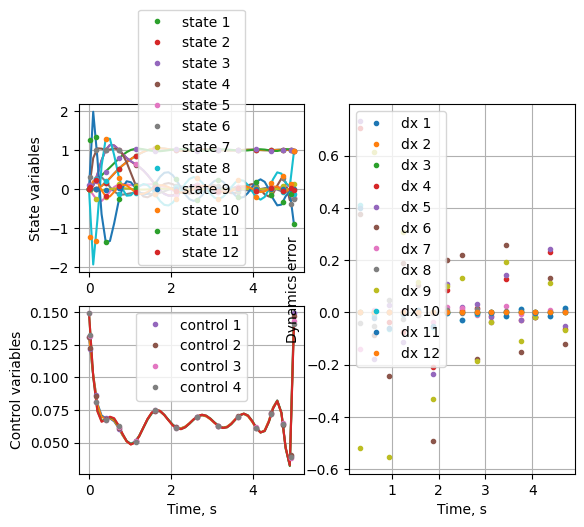

In [10]:
# Řešení
sim_time = 600
position = np.zeros([sim_time, 3])
input = np.zeros([sim_time, 4])

mpo, post = mp.solve(ocp, n_segments=1, poly_orders=15, scheme="LGR", plot=True)
data = post.get_data()
inputs = data[1]

# print(inputs)

146.059


C:\Users\Ondra\AppData\Local\Temp\ipykernel_5972\2305021465.py:36: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(['x', 'y', 'z', '_', '_', '_', 'ref'])
C:\Users\Ondra\AppData\Local\Temp\ipykernel_5972\2305021465.py:49: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax2.legend([r'$u_1$', r'$u_2$', r'$u_3$', r'$u_4$', '_', '_', '_', '_'])


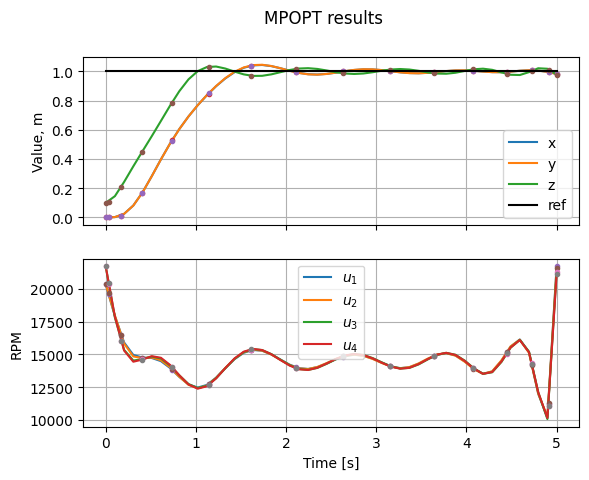

In [ ]:
# Data
data = post.get_data()
state = data[0].T
input = data[1].T
position = state[0:3,:]
orientation = state[6:9,:]
t = data[2]

# Interpolovana data
data_inter = post.get_data(interpolate=True)
state_inter = data_inter[0].T
input_i = data_inter[1].T
position_i = state_inter[0:3,:]
orientation_i = state_inter[6:9,:]
t_i = data_inter[2]

J_val = post.solution
J_val = J_val['f']

ref = np.ones([1, np.size(t_i)])


fig, (ax1, ax2) = plt.subplots(2, sharex = True)
fig.suptitle('MPOPT results')
ax1.plot(t_i, position_i[0])
ax1.plot(t_i, position_i[1])
ax1.plot(t_i, position_i[2])
ax1.plot(t, position[0], '.')
ax1.plot(t, position[1], '.')
ax1.plot(t, position[2], '.')
ax1.plot(t_i, ref[0], color='black')
ax1.set(ylabel = 'Value, m')
ax1.grid(True)
ax1.legend(['x', 'y', 'z', '_', '_', '_', 'ref'])

ax2.plot(t_i, np.sqrt(input_i[0]/C_T2))
ax2.plot(t_i, np.sqrt(input_i[1]/C_T2))
ax2.plot(t_i, np.sqrt(input_i[2]/C_T2))
ax2.plot(t_i, np.sqrt(input_i[3]/C_T2))
ax2.plot(t, np.sqrt(input[0]/C_T2), '.')
ax2.plot(t, np.sqrt(input[1]/C_T2), '.')
ax2.plot(t, np.sqrt(input[2]/C_T2), '.')
ax2.plot(t, np.sqrt(input[3]/C_T2), '.')
ax2.set(xlabel = 'Time [s]')
ax2.set(ylabel = 'RPM')
ax2.grid(True)
ax2.legend([r'$u_1$', r'$u_2$', r'$u_3$', r'$u_4$', '_', '_', '_', '_'])

print(J_val)


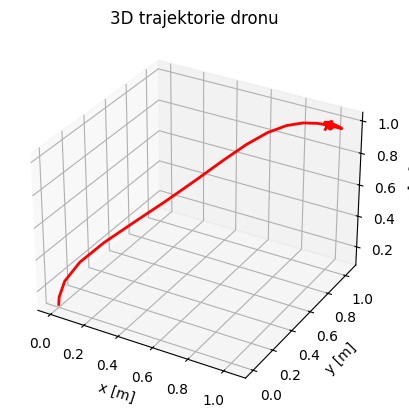

In [14]:
# 3D trajektorie (poloha v prostoru)
data = post.get_data(interpolate=True)
data = data[0]
position = np.zeros([3, np.size(data,0)])

for i in range(np.size(data,0)):
    position[0][i] = data[i][0]
    position[1][i] = data[i][1]
    position[2][i] = data[i][2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(position[0], position[1], position[2], 'r', linewidth=2)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D trajektorie dronu')
plt.show()

# plt.plot(position[0],position[1])